In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [45]:
# convert the position label to the position number
def pos_to_num(row):
    if row['Pos'] == 'PG':
        return 1
    if row['Pos'] == 'SG':
        return 2
    if row['Pos'] == 'SF':
        return 3
    if row['Pos'] == 'PF':
        return 4
    if row['Pos'] == 'C':
        return 5
    return 1
    

In [46]:
# need to remove * next to name so lookup is easy
def remove_star_from_player(row):
    newname = row['Player'].replace("*", "")
    return newname
        

In [47]:
# Player name has an id attached to it, need this to extract only the name
def change_player_name(row):
    name = row['Player']
    x = name.split('\\')
    return x[0]

# Get Player Heights

In [48]:
# get the player heights from the Players.csv file and merge with the old_players df on "Player" column
player_heights = pd.read_csv('Players.csv')
player_heights['Player'] = player_heights['Player'].astype(str)
player_heights['Player'] = player_heights.apply (lambda row: remove_star_from_player(row), axis=1)
player_heights = player_heights[['Player','height','weight']]
player_heights

,Player,height,weight
0,Curly Armstrong,180.0,77.0
1,Cliff Barker,188.0,83.0
2,Leo Barnhorst,193.0,86.0
3,Ed Bartels,196.0,88.0
4,Ralph Beard,178.0,79.0
...,...,...,...
3917,Troy Williams,198.0,97.0
3918,Kyle Wiltjer,208.0,108.0
3919,Stephen Zimmerman,213.0,108.0
3920,Paul Zipser,203.0,97.0


# 2015-16 NBA Stats

In [49]:
# get the player data from the CSV
# remove NaN rows
# remove player who have not played many minutes/games that season
players = pd.read_csv('Players_Yearly/players_2015.csv')
players = players[players['Pos'].isin(['PG','SG','SF','PF','C'])]
players = players[players['G'] >= 45]
players = players[players['MP'] > 200]
players['Player'] = players.apply (lambda row: change_player_name(row), axis=1)
players['Player'] = players.apply (lambda row: remove_star_from_player(row), axis=1)
players['Pos#'] = players.apply (lambda row: pos_to_num(row), axis=1)

In [50]:
players = pd.merge(left=players, right=player_heights, left_on='Player', right_on='Player')
players

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,Pos#,height,weight
0,1,Quincy Acy,PF,25,SAC,59,29,876,119,214,...,188,27,29,24,27,103,307,4,201.0,108.0
1,3,Steven Adams,C,22,OKC,80,80,2014,261,426,...,533,62,42,89,84,223,636,5,213.0,115.0
2,4,Arron Afflalo,SG,30,NYK,71,57,2371,354,799,...,266,144,25,10,82,142,909,2,196.0,95.0
3,6,Cole Aldrich,C,27,LAC,60,5,800,134,225,...,288,50,47,68,64,139,328,5,211.0,113.0
4,7,LaMarcus Aldridge,PF,30,SAS,74,74,2261,536,1045,...,632,110,38,81,99,151,1331,4,211.0,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,465,Jeff Withey,C,25,UTA,51,10,658,87,162,...,173,20,21,53,28,75,217,5,213.0,104.0
311,473,Nick Young,SG,30,LAL,54,2,1033,126,372,...,97,34,23,7,30,50,392,2,201.0,95.0
312,474,Thaddeus Young,PF,27,BRK,73,73,2407,495,963,...,660,135,112,37,136,182,1102,4,203.0,100.0
313,475,Cody Zeller,C,23,CHO,73,60,1774,231,437,...,455,71,57,63,68,204,638,5,213.0,108.0


# Predicting Position From Player Size

In [51]:
X_size = np.array(players[['weight','height']])
y = np.array(players['Pos'])

Text(0.5, 1.0, 'Paramter Value vs Accuracy (Player Size 2015)')

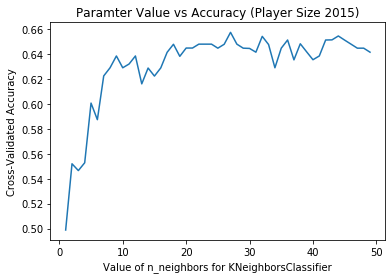

In [52]:
# find the best paramters for the different model and plot them

k_range = range(1,50)
k_scores = []
for k in k_range:
    svc = make_pipeline(
        StandardScaler(),
#         SVC(kernel='linear', C=k) #0.638
#         LogisticRegression(C=k)
#         GaussianNB()
        KNeighborsClassifier(n_neighbors=k) #0.66
#         RandomForestClassifier(n_estimators=k)
    )
    scores = cross_val_score(svc,X_size,y,cv=10,scoring='accuracy')
    k_scores.append(scores.mean())

plt.plot(k_range,k_scores)
plt.xlabel('Value of n_neighbors for KNeighborsClassifier')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Paramter Value vs Accuracy (Player Size 2015)')

In [53]:
# use the model and paramter that yield the highest accuracy for cross-validation and print the score
model_size = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=57)
    )
scores_size = cross_val_score(model_size,X_size,y,cv=10,scoring='accuracy')
print("Player Size - Cross Validation Prediction Accuracy: {0:.1f}%".format(np.mean(scores_size) * 100))

Player Size - Cross Validation Prediction Accuracy: 66.1%


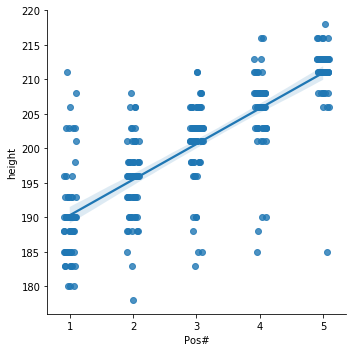

In [54]:
# Plot Position Vs. Height
sns.lmplot(x='Pos#', y='height',data=players,x_jitter=.1)

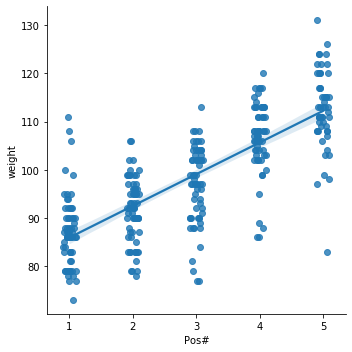

In [55]:
# Plot Position Vs. Weight
sns.lmplot(x='Pos#', y='weight',data=players,x_jitter=.1)

# Predicting Position From Stats

In [56]:
X_stats = np.array(players[['ORB','DRB','AST','BLK','3PA','3P']])
y = np.array(players['Pos'])
X_train_stats, X_test_stats, y_train_stats, y_test_stats = train_test_split(X_stats, y)

Text(0.5, 1.0, 'Paramter Value vs Accuracy (Player Stats 2015)')

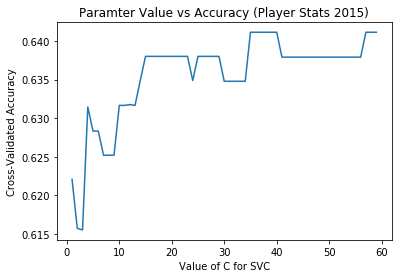

In [57]:
# find the best paramters for the different model and plot them
k_range = range(1,60)
k_scores = []
for k in k_range:
    svc = make_pipeline(
        StandardScaler(),
        SVC(kernel='linear', C=k) #0.642
#         LogisticRegression(C=k)
#         GaussianNB()
#         KNeighborsClassifier(n_neighbors=k)
#         RandomForestClassifier(n_estimators=k)
    )
    scores = cross_val_score(svc,X_stats,y,cv=10,scoring='accuracy')
    k_scores.append(scores.mean())

plt.plot(k_range,k_scores)
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Paramter Value vs Accuracy (Player Stats 2015)')

In [58]:
# use the model and paramter that yield the highest accuracy for cross-validation and print the score
model_stats = make_pipeline(
        StandardScaler(),
        SVC(kernel='linear', C=36)
    )
model_stats.fit(X_train_stats,y_train_stats)
scores_stats = cross_val_score(model_stats,X_stats,y,cv=10,scoring='accuracy')
print("Player Stats - Cross Validation Preiction Accuracy: {0:.1f}%".format(np.mean(scores_stats) * 100))

Player Stats - Cross Validation Preiction Accuracy: 64.1%


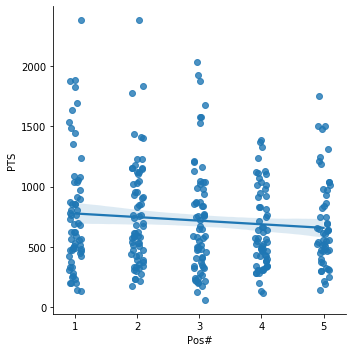

In [59]:
# Plot Position Vs. Total Points
sns.lmplot(x='Pos#', y='PTS',data=players,x_jitter=.1)


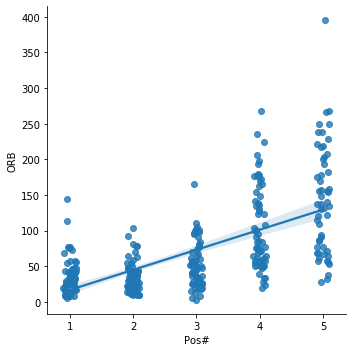

In [60]:
# Plot Position Vs. Total Offensive Rebounds
sns.lmplot(x='Pos#', y='ORB',data=players,x_jitter=.1)

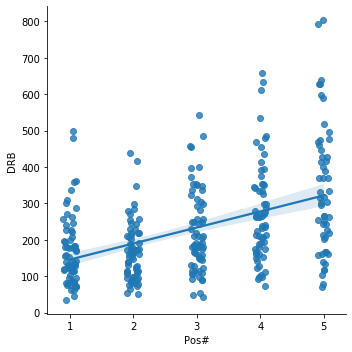

In [61]:
# Plot Position Vs. Total Deffensive Rebounds
sns.lmplot(x='Pos#', y='DRB',data=players,x_jitter=.1)

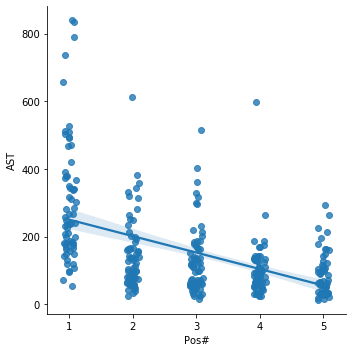

In [62]:
# Plot Position Vs. Total Assists
sns.lmplot(x='Pos#', y='AST',data=players,x_jitter=.1)

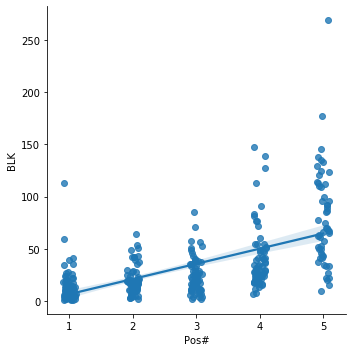

In [63]:
# Plot Position Vs. Total Blocks
sns.lmplot(x='Pos#', y='BLK',data=players,x_jitter=.1)

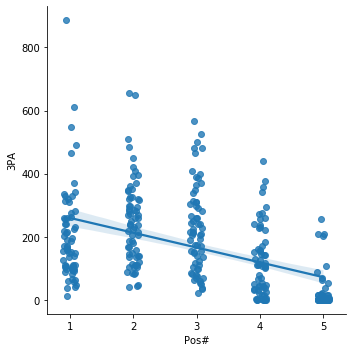

In [64]:
# Plot Position Vs. Total 3-Point Attempts
sns.lmplot(x='Pos#', y='3PA',data=players,x_jitter=.1)

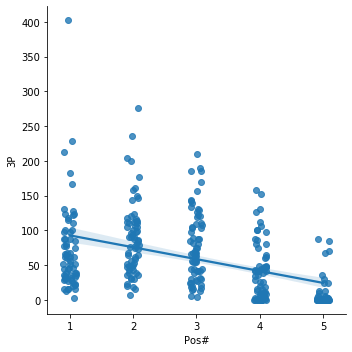

In [65]:
# Plot Position Vs. Total 3-Point made
sns.lmplot(x='Pos#', y='3P',data=players,x_jitter=.1)

# 1995-96 NBA stats

In [66]:
# get the player data from the CSV
# remove player who have not played many minutes/games that season
old_players = pd.read_csv('Players_Yearly/players_1996.csv')
old_players = old_players[old_players['Pos'].isin(['PG','SG','SF','PF','C'])]
old_players = old_players[old_players['G'] >= 45]
old_players = old_players[old_players['MP'] > 200]
old_players['Player'] = old_players.apply (lambda row: change_player_name(row), axis=1)
old_players['Player'] = old_players.apply (lambda row: remove_star_from_player(row), axis=1)
old_players['Pos#'] = old_players.apply (lambda row: pos_to_num(row), axis=1)

In [67]:
# merge with player_heights df to get weight and height of the player
old_players = pd.merge(left=old_players, right=player_heights, left_on='Player', right_on='Player')
old_players

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,Pos#,height,weight
0,1,Mahmoud Abdul-Rauf,PG,26,DEN,57,53,2029,414,955,...,138,389,64,3,115,117,1095,1,188.0,83.0
1,3,Rafael Addison,SF,31,CHH,53,0,516,77,165,...,90,30,9,9,27,74,171,3,201.0,97.0
2,4,Cory Alexander,PG,22,SAS,60,0,560,63,155,...,42,121,27,2,68,94,168,1,185.0,83.0
3,6,Derrick Alston,C,23,PHI,73,41,1614,198,387,...,302,61,56,52,59,191,452,5,211.0,102.0
4,8,Ashraf Amaya,PF,24,VAN,54,34,1104,121,252,...,303,33,22,10,57,151,339,4,203.0,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,424,Joe Wolf,PF,31,ORL,63,8,1047,135,262,...,185,63,13,5,40,161,291,4,211.0,104.0
311,425,David Wood,PF,31,TOT,62,0,772,75,174,...,154,34,19,10,24,150,208,4,206.0,102.0
312,427,Haywoode Workman,PG,30,IND,77,4,1164,101,259,...,124,213,65,4,93,152,279,1,188.0,81.0
313,428,Sharone Wright,C,23,TOT,57,38,1434,248,512,...,356,38,30,49,109,163,664,5,211.0,117.0


# Predicting Position From Player Size(Old Generation)

In [68]:
X_size_old = np.array(old_players[['weight','height']])
y_old = np.array(old_players['Pos'])

Text(0, 0.5, 'Cross-Validated Accuracy')

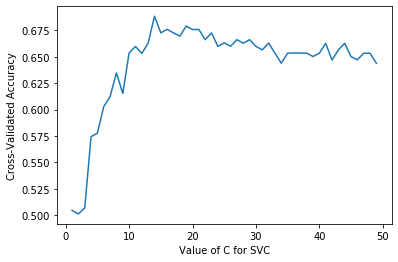

In [69]:
# find the best paramters for the different model and plot them
k_range = range(1,50)
k_scores = []
for k in k_range:
    svc = make_pipeline(
        StandardScaler(),
#         SVC(kernel='linear', C=k)
#         GaussianNB()
#         LogisticRegression(C=k)
        KNeighborsClassifier(n_neighbors=k)
#         RandomForestClassifier(n_estimators=k)
    )
    scores = cross_val_score(svc,X_size_old,y_old,cv=10,scoring='accuracy')
    k_scores.append(scores.mean())

plt.plot(k_range,k_scores)
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated Accuracy')

In [70]:
# use the model and paramter that yield the highest accuracy for cross-validation and print the score
model_size_old = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=14)
    )
scores_size_old = cross_val_score(model_size_old,X_size_old,y_old,cv=10,scoring='accuracy')
print("Player Size (Old) - Cross Validation Preiction Accuracy: {0:.1f}%".format(np.mean(scores_size_old) * 100))

Player Size (Old) - Cross Validation Preiction Accuracy: 68.8%


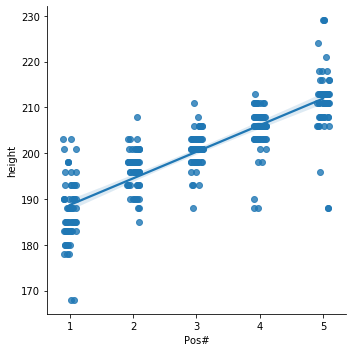

In [71]:
# Plot Position Vs. Height
sns.lmplot(x='Pos#', y='height',data=old_players,x_jitter=.1)

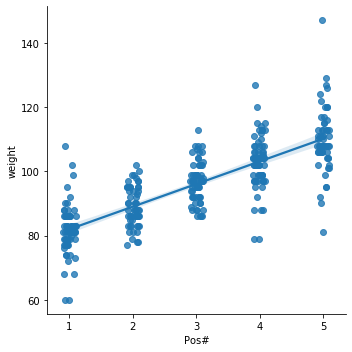

In [72]:
# Plot Position Vs. Weight
sns.lmplot(x='Pos#', y='weight',data=old_players,x_jitter=.1)

In [73]:
X_stats_old = np.array(old_players[['ORB','DRB','AST','BLK','3PA','3P']])
y_old = np.array(old_players['Pos'])

X_train_stats_old, X_test_stats_old, y_train_stats_old, y_test_stats_old = train_test_split(X_stats_old, y_old)

Text(0, 0.5, 'Cross-Validated Accuracy')

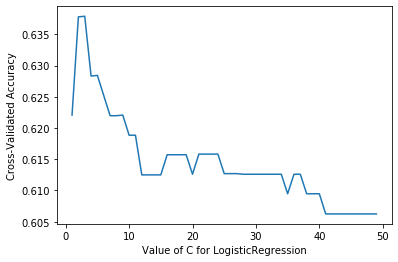

In [74]:
# find the best paramters for the different model and plot them
k_range = range(1,50)
k_scores = []
for k in k_range:
    svc = make_pipeline(
        StandardScaler(),
        SVC(kernel='linear', C=k) #0.637
#         GaussianNB()
#         LogisticRegression(C=k)
#         KNeighborsClassifier(n_neighbors=k)
#         RandomForestClassifier(n_estimators=k)
    )
    scores = cross_val_score(svc,X_stats_old,y_old,cv=10,scoring='accuracy')
    k_scores.append(scores.mean())

plt.plot(k_range,k_scores)
plt.xlabel('Value of C for LogisticRegression')
plt.ylabel('Cross-Validated Accuracy')

In [75]:
# use the model and paramter that yield the highest accuracy for cross-validation and print the score
model_stats_old = make_pipeline(
        StandardScaler(),
        SVC(kernel='linear', C=3)
    )
model_stats_old.fit(X_train_stats_old,y_train_stats_old)
scores_stats_old = cross_val_score(model_stats_old,X_stats_old,y_old,cv=10,scoring='accuracy')
print("Player Stats (Old) - Cross Validation Preiction Accuracy: {0:.1f}%".format(np.mean(scores_stats_old) * 100))

Player Stats (Old) - Cross Validation Preiction Accuracy: 63.8%


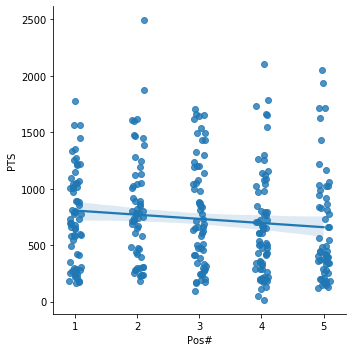

In [76]:
# Plot Position Vs. Total Points
sns.lmplot(x='Pos#', y='PTS',data=old_players,x_jitter=.1)

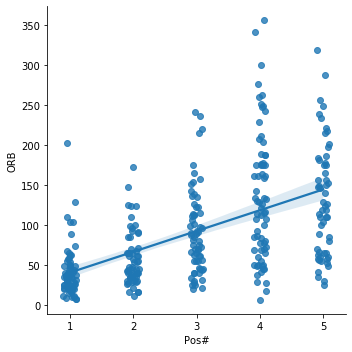

In [77]:
# Plot Position Vs. Total Offensive Rebounds
sns.lmplot(x='Pos#', y='ORB',data=old_players,x_jitter=.1)

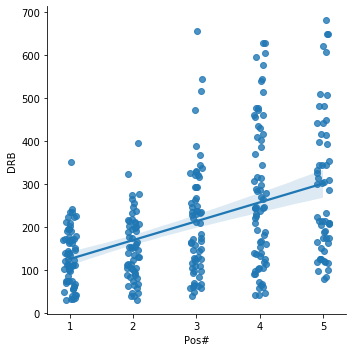

In [78]:
# Plot Position Vs. Total Defensive Rebounds
sns.lmplot(x='Pos#', y='DRB',data=old_players,x_jitter=.1)

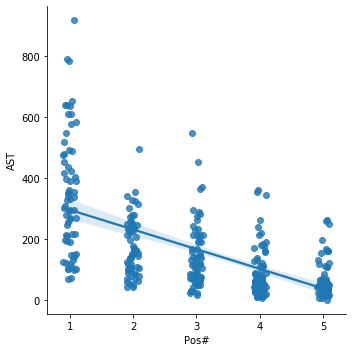

In [79]:
# Plot Position Vs. Total Assists
sns.lmplot(x='Pos#', y='AST',data=old_players,x_jitter=.1)

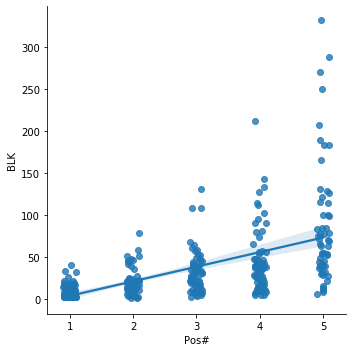

In [80]:
# Plot Position Vs. Total Blocks
sns.lmplot(x='Pos#', y='BLK',data=old_players,x_jitter=.1)

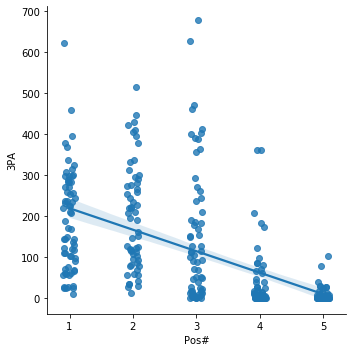

In [81]:
# Plot Position Vs. Total 3-Point Attempts
sns.lmplot(x='Pos#', y='3PA',data=old_players,x_jitter=.1)

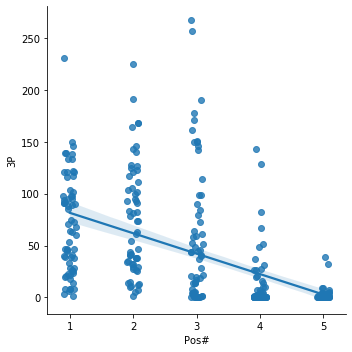

In [82]:
# Plot Position Vs. Total 3-Point Made
sns.lmplot(x='Pos#', y='3P',data=old_players,x_jitter=.1)

# Use The 2 Stats Model To Prdict Last Season's Player Positions

In [83]:
file_names = ['players_1997','players_1998','players_1999',
              'players_2000','players_2001','players_2002',
              'players_2003','players_2004','players_2005',
              'players_2006','players_2007','players_2008',
              'players_2009','players_2010','players_2011',
              'players_2012','players_2013','players_2014']


In [84]:
def get_player_df(title):
    players_df = pd.read_csv('Players_Yearly/'+ title + '.csv')
    players_df = players_df[players_df['Pos'].isin(['PG','SG','SF','PF','C'])]
    players_df = players_df[players_df['G'] >= 45]
    players_df = players_df[players_df['MP'] > 200]
    players_df['Player'] = players_df.apply (lambda row: change_player_name(row), axis=1)
    players_df['Player'] = players_df.apply (lambda row: remove_star_from_player(row), axis=1)
    return players_df

In [85]:
def predict_position_yearly():
    
    accuracy_scores = []
    for title in file_names:
        year = title.split('_')[1]
        players_df = get_player_df(title)
        players_df_pos = np.array(players_df['Pos'])
        players_df_stats = players_df[['ORB','DRB','AST','BLK','3PA','3P']]
        
        player_predicted_old = model_stats_old.predict(players_df_stats)
        accuracy_old = np.mean(players_df_pos == player_predicted_old) * 100
        
        player_predicted = model_stats.predict(players_df_stats)
        accuracy = np.mean(players_df_pos == player_predicted) * 100
        
        lis = [year,accuracy_old,accuracy]
        accuracy_scores.append(lis)
        
    plt.figure(figsize=(10,5))
    df = pd.DataFrame(accuracy_scores, columns = ['Year','1996 Model', '2015 Model'])
    df = pd.melt(df, id_vars=['Year'], value_vars=['1996 Model', '2015 Model'])
    g = sns.lineplot(x="Year", y="value", hue='variable', data=df)
    g.set_title('Position Prediction Accuracy From 2 Models')
    g.set_ylabel('Accuracy %')
    g.set_xticklabels(df['Year'],rotation=45)
    

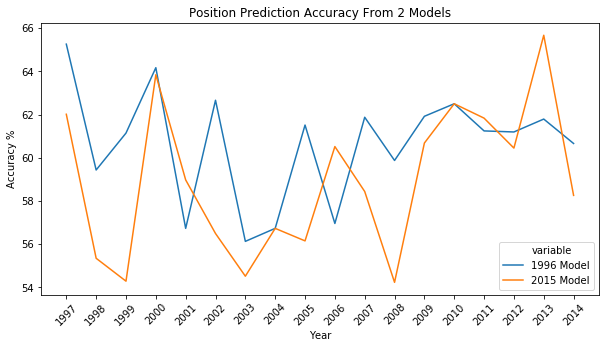

In [86]:
predict_position_yearly()
